In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from torchsummary import summary
from sklearn.metrics import confusion_matrix as cfm

# Problem 1

In [154]:
batch_size = 50

cifar_trainset = torchvision.datasets.CIFAR10(
    root = os.getcwd(),
    train = True,
    transform = transforms.ToTensor(), 
    download = True
)

cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)

cifar_testset = torchvision.datasets.CIFAR10(
    root = os.getcwd(),
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [155]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.hidden1 = nn.Linear(3*32*32, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

model1 = Net1()
summary(model1, input_size=(1, 1, 3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 256]         786,688
           Dropout-2            [-1, 1, 1, 256]               0
            Linear-3            [-1, 1, 1, 128]          32,896
           Dropout-4            [-1, 1, 1, 128]               0
            Linear-5             [-1, 1, 1, 10]           1,290
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 3.13
Estimated Total Size (MB): 3.15
----------------------------------------------------------------


In [156]:
def train(input_size, epochs, optimizer, loss_func, model, train_loader):
    count = 0
    for epoch in range(epochs):
        correct = 0
        for images, labels in train_loader:
            count += 1
            inp = images.view(-1, input_size)

            outputs = model(inp)
            loss = loss_func(outputs, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            predictions = torch.max(outputs, 1)[1]
            correct += (predictions == labels).sum().numpy()

        print(f"Epochs: {epoch+1}, Iteration: {count}, Loss: {loss.data}, Accuracy: {100*(correct/len(train_loader.dataset))}")

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4, weight_decay=1e-4)
epochs = 25
train(3*32*32, epochs, optimizer, loss_func, model1, cifar_train_loader)

Epochs: 1, Iteration: 1000, Loss: 1.8492709398269653, Accuracy: 25.259999999999998
Epochs: 2, Iteration: 2000, Loss: 1.910331130027771, Accuracy: 32.550000000000004
Epochs: 3, Iteration: 3000, Loss: 1.7772815227508545, Accuracy: 35.696
Epochs: 4, Iteration: 4000, Loss: 1.7605689764022827, Accuracy: 37.112
Epochs: 5, Iteration: 5000, Loss: 1.6276189088821411, Accuracy: 38.45
Epochs: 6, Iteration: 6000, Loss: 1.519078016281128, Accuracy: 39.804
Epochs: 7, Iteration: 7000, Loss: 1.7946220636367798, Accuracy: 40.802
Epochs: 8, Iteration: 8000, Loss: 1.5893592834472656, Accuracy: 41.738
Epochs: 9, Iteration: 9000, Loss: 1.376906156539917, Accuracy: 42.338
Epochs: 10, Iteration: 10000, Loss: 1.5649025440216064, Accuracy: 43.042
Epochs: 11, Iteration: 11000, Loss: 1.6559338569641113, Accuracy: 43.663999999999994
Epochs: 12, Iteration: 12000, Loss: 1.599697232246399, Accuracy: 44.076
Epochs: 13, Iteration: 13000, Loss: 1.5356231927871704, Accuracy: 44.584
Epochs: 14, Iteration: 14000, Loss: 1.

In [182]:
def test(input_size, loss_func, model, test_loader, total_size, plot_cfm=False, plot_weights=False):
    with torch.no_grad():
        total = 0
        correct = 0

        y_pred = np.zeros((len(test_loader), int(total_size/len(test_loader))))
        y_true = y_pred.copy()
        for i, (images, labels) in enumerate(test_loader):
            model.eval()
            device = "cpu"
            images = images.to(device)

            test = images.view(-1, input_size)
            outputs = model(test).cpu()
            loss = loss_func(outputs, labels)

            predictions = torch.max(outputs, 1)[1]
            correct += (predictions == labels).sum().numpy()
            total += len(labels)
            y_pred[i] = predictions
            y_true[i] = labels

        accuracy = 100*(correct/total)
        print(f"Loss: {loss.data}, Accuracy: {accuracy}")

        if (plot_cfm):
            conf = cfm(y_true.flatten(), y_pred.flatten())
            xticks = np.linspace(1, 10, num=10, dtype=np.int64)
            yticks = xticks.copy()
            ax = sns.heatmap(conf)
            ax.set_xticklabels(xticks)
            ax.set_yticklabels(yticks)
            return conf

        if (plot_weights):
            for name, param in model.named_parameters():
                if name == "hidden.weight" or name == "output.weight":
                    hist = torch.histc(param.data).numpy()
                    plt.figure()
                    plt.plot(range(len(hist)), hist)
                    plt.xlabel("bins")
                    plt.ylabel("Frequency")

            plt.show()

## Part a)

In [183]:
print("Final Training Loss and Accuracy:")
test(3*32*32, loss_func, model1, cifar_train_loader, len(cifar_trainset))

Final Training Loss and Accuracy:
Loss: 1.4039660692214966, Accuracy: 53.412000000000006


Testing Loss and Accuracy:
Loss: 1.352978229522705, Accuracy: 50.739999999999995
Confusion Matrix:
[[569  33  44  25  26  17  30  41 176  39]
 [ 42 636   3  17   7  19  20  30  95 131]
 [ 96  29 266 102 135  72 165  90  29  16]
 [ 28  23  58 328  40 177 182  79  34  51]
 [ 64  15  98  57 382  46 173 120  34  11]
 [ 21  18  72 199  47 352 117 113  38  23]
 [  8  18  40  73  84  44 669  27  18  19]
 [ 36  20  32  53  57  75  39 635  13  40]
 [102  50   5  20  12  18  17  18 707  51]
 [ 50 188   3  30   8  20  30  54  87 530]]


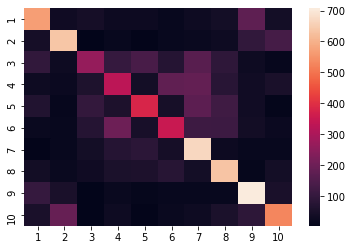

In [184]:
print("Testing Loss and Accuracy:")
conf = test(3*32*32, loss_func, model1, cifar_test_loader, len(cifar_testset), True)
print(f"Confusion Matrix:\n{conf}")

## Part b)

In [185]:
most_likely_conf = np.argsort(conf)[:, -2]+1
for i, m in enumerate(most_likely_conf):
    print(f"Class {m} is most likely to be confused with class {i+1}")

Class 9 is most likely to be confused with class 1
Class 10 is most likely to be confused with class 2
Class 7 is most likely to be confused with class 3
Class 7 is most likely to be confused with class 4
Class 7 is most likely to be confused with class 5
Class 4 is most likely to be confused with class 6
Class 5 is most likely to be confused with class 7
Class 6 is most likely to be confused with class 8
Class 1 is most likely to be confused with class 9
Class 2 is most likely to be confused with class 10


## Part c)

In [186]:
diags = np.diagonal(conf)
two_most_conf = np.argsort(diags)[:2]+1
print(f"The two classes that are most likely to be confused overall are classes {two_most_conf[0]} and {two_most_conf[1]} in descending order of confusion")

The two classes that are most likely to be confused overall are classes 3 and 4 in descending order of confusion


# Problem 2

In [162]:
batch_size = 100

mnist_trainset = torchvision.datasets.FashionMNIST(
    root = os.getcwd(),
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

mnist_testset = torchvision.datasets.FashionMNIST(
    root = os.getcwd(),
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

## First Model

In [163]:
class Net21(nn.Module):
    def __init__(self):
        super(Net21, self).__init__()
        self.hidden = nn.Linear(28*28, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x

model_mnist1 = Net21()
summary(model_mnist1, input_size=(1, 1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 128]         100,480
            Linear-2             [-1, 1, 1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [164]:
loss_func = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model_mnist1.parameters(), lr=0.0001)
epochs = 40
train(28*28, epochs, optimizer1, loss_func, model_mnist1, mnist_train_loader)

Epochs: 1, Iteration: 600, Loss: 0.558773934841156, Accuracy: 69.18333333333334
Epochs: 2, Iteration: 1200, Loss: 0.4620964825153351, Accuracy: 80.33
Epochs: 3, Iteration: 1800, Loss: 0.49546486139297485, Accuracy: 82.57166666666666
Epochs: 4, Iteration: 2400, Loss: 0.555185079574585, Accuracy: 83.645
Epochs: 5, Iteration: 3000, Loss: 0.4303450286388397, Accuracy: 84.41833333333332
Epochs: 6, Iteration: 3600, Loss: 0.5488499402999878, Accuracy: 84.94166666666668
Epochs: 7, Iteration: 4200, Loss: 0.4064674377441406, Accuracy: 85.385
Epochs: 8, Iteration: 4800, Loss: 0.40752941370010376, Accuracy: 85.54166666666667
Epochs: 9, Iteration: 5400, Loss: 0.38283270597457886, Accuracy: 85.90666666666667
Epochs: 10, Iteration: 6000, Loss: 0.4455450475215912, Accuracy: 86.115
Epochs: 11, Iteration: 6600, Loss: 0.3175296485424042, Accuracy: 86.36
Epochs: 12, Iteration: 7200, Loss: 0.42137372493743896, Accuracy: 86.59333333333333
Epochs: 13, Iteration: 7800, Loss: 0.4270581007003784, Accuracy: 86.7

Loss: 0.41373467445373535, Accuracy: 87.41


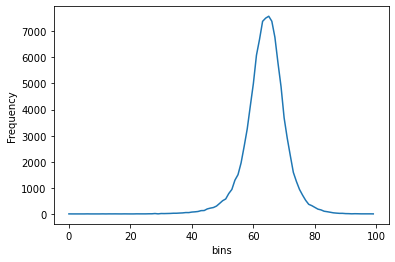

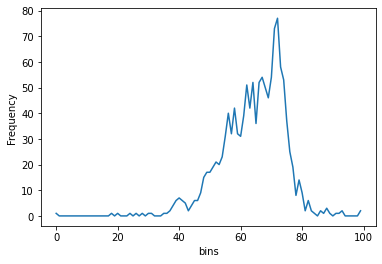

In [165]:
test(28*28 ,loss_func, model_mnist1, mnist_test_loader, len(mnist_testset), plot_weights=True)

## Second Model

In [166]:
class Net22(nn.Module):
    def __init__(self):
        super(Net22, self).__init__()
        self.hidden = nn.Linear(28*28, 48)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(48, 10)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

model_mnist2 = Net22()
summary(model_mnist2, input_size=(1, 1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 1, 48]          37,680
           Dropout-2             [-1, 1, 1, 48]               0
            Linear-3             [-1, 1, 1, 10]             490
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [167]:
loss_func = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model_mnist2.parameters(), lr=0.0001, weight_decay=1e-4)
train(28*28, epochs, optimizer2, loss_func, model_mnist2, mnist_train_loader)

Epochs: 1, Iteration: 600, Loss: 0.9805886745452881, Accuracy: 61.75333333333334
Epochs: 2, Iteration: 1200, Loss: 0.8425123691558838, Accuracy: 73.85333333333334
Epochs: 3, Iteration: 1800, Loss: 0.5461411476135254, Accuracy: 77.61
Epochs: 4, Iteration: 2400, Loss: 0.4412006735801697, Accuracy: 79.34666666666666
Epochs: 5, Iteration: 3000, Loss: 0.512324869632721, Accuracy: 80.81166666666667
Epochs: 6, Iteration: 3600, Loss: 0.38565754890441895, Accuracy: 81.39333333333333
Epochs: 7, Iteration: 4200, Loss: 0.5554752945899963, Accuracy: 82.14666666666666
Epochs: 8, Iteration: 4800, Loss: 0.4795358180999756, Accuracy: 82.8
Epochs: 9, Iteration: 5400, Loss: 0.35045865178108215, Accuracy: 83.19166666666666
Epochs: 10, Iteration: 6000, Loss: 0.5023282766342163, Accuracy: 83.61
Epochs: 11, Iteration: 6600, Loss: 0.4590279459953308, Accuracy: 83.68333333333334
Epochs: 12, Iteration: 7200, Loss: 0.39936143159866333, Accuracy: 84.11166666666666
Epochs: 13, Iteration: 7800, Loss: 0.513966798782

Loss: 0.444126695394516, Accuracy: 86.68


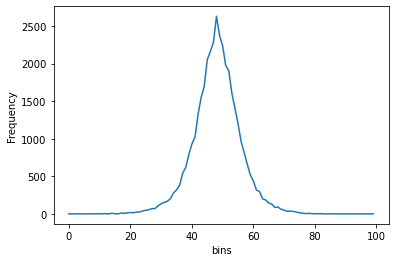

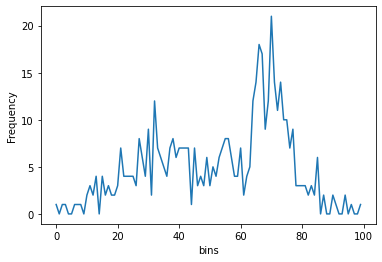

In [168]:
test(28*28, loss_func, model_mnist2, mnist_test_loader, len(mnist_testset), plot_weights=True)

### Note: The first histogram plot for both models corresponds with the input layer weights and the second histogram corresponds with the hidden layer weights. The plots appear to be sharper for the model with regularization. Also, the frequencies seem to be lower, by approximately a factor of 3, across the board for the model with regularization. This seems to be because the effect from L2 regularization leads to the weights to be constrained within smaller values which causes the frequencies to go down.